# 1.Import Files

In [1]:
import pandas as pd
# set screen
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
 
import matplotlib.pyplot as plt
from pandas import read_excel
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from numpy import concatenate
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
import os
import pandas as pd

Using TensorFlow backend.


# 2.Load and Clean Data

In [6]:
# Convert the string to the float
def str_to_float(s):
    s=s[:-1]
    s_float=float(s)
    return s_float
path=""
excelFile = os.path.join(path,'btc-usd-max.csv')

stock_data = pd.read_csv(excelFile,parse_dates=['Date'],index_col='Date')
# Read excel file, transfer the 'date' column to Datetime format and set it to the index
stock_data.columns=['price','market_cap','volume']
stock_data.index.name='date' # set the date column to the index column
# Sort the data according to the datetime
stock_data=stock_data.sort_values(by='date')
# Add a column named 'earn_rate'
stock_data['earn_rate'] = stock_data['price'].pct_change()
# Fill the missing value
stock_data['earn_rate'].fillna(method='bfill',inplace=True)

stock_data = stock_data.iloc[2500:2926]
print(stock_data.head())

                                 price    market_cap        volume  earn_rate
date                                                                         
2020-03-04 00:00:00+00:00  8756.718577  1.598170e+11  6.833604e+10  -0.016748
2020-03-05 00:00:00+00:00  8758.646993  1.598700e+11  3.883207e+10   0.000220
2020-03-06 00:00:00+00:00  9038.870323  1.650700e+11  3.812264e+10   0.031994
2020-03-07 00:00:00+00:00  9135.845066  1.667910e+11  4.138809e+10   0.010729
2020-03-08 00:00:00+00:00  8902.201950  1.625430e+11  3.676476e+10  -0.025574


### Nomalization

In [7]:
# Gain the values of the stock_data, format:array
values=stock_data.values
# Ensure all the data type is float32
values=values.astype('float32')
# Normalization of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[0.06361379 0.06192337 0.32307675 0.6156715 ]
 [0.06364674 0.06197172 0.14243007 0.6468422 ]
 [0.06843326 0.06671722 0.13808635 0.70520973]
 ...
 [0.9018149  0.9041594  0.23455957 0.791479  ]
 [0.9015494  0.9024985  0.17387062 0.64594394]
 [0.8808433  0.88146317 0.1439032  0.6079198 ]]


### Supervised Function

In [8]:
# Transfer the problem into supervised problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
# delete the columns exclude 'earn_rate'
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)   var4(t)
1     0.063614   0.061923   0.323077   0.615672  0.063647  0.061972  0.142430  0.646842
2     0.063647   0.061972   0.142430   0.646842  0.068433  0.066717  0.138086  0.705210
3     0.068433   0.066717   0.138086   0.705210  0.070090  0.068288  0.158080  0.666146
4     0.070090   0.068288   0.158080   0.666146  0.066099  0.064411  0.129772  0.599458
5     0.066099   0.064411   0.129772   0.599458  0.051395  0.050297  0.144268  0.468803
..         ...        ...        ...        ...       ...       ...       ...       ...
421   0.853361   0.853875   0.201432   0.680912  0.850266  0.851147  0.199010  0.640385
422   0.850266   0.851147   0.199010   0.640385  0.829531  0.830467  0.192184  0.605753
423   0.829531   0.830467   0.192184   0.605753  0.901815  0.904159  0.234560  0.791479
424   0.901815   0.904159   0.234560   0.791479  0.901549  0.902498  0.173871  0.645944
425   0.901549   0.902498   0.17

# 3.Split Data Set

In [16]:
# split the data into train set and test set
split_size = 0.75
values = reframed.values
#train = np.concatenate([values[:len(values)*split_size, :],values[488:,:]])
split_position = int(len(values)*split_size)
train = values[:split_position, :]
test = values[split_position:len(values), :]
# split the input data and label from train set and test set
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(318, 1, 4) (318,)
(107, 1, 4) (107,)


# 4.Build Machine Learning Model

Train on 318 samples, validate on 107 samples
Epoch 1/50
 - 1s - loss: 0.6411 - val_loss: 0.5840
Epoch 2/50
 - 0s - loss: 0.6172 - val_loss: 0.5427
Epoch 3/50
 - 0s - loss: 0.5919 - val_loss: 0.4998
Epoch 4/50
 - 0s - loss: 0.5618 - val_loss: 0.4556
Epoch 5/50
 - 0s - loss: 0.5306 - val_loss: 0.4098
Epoch 6/50
 - 0s - loss: 0.5013 - val_loss: 0.3621
Epoch 7/50
 - 0s - loss: 0.4679 - val_loss: 0.3121
Epoch 8/50
 - 0s - loss: 0.4389 - val_loss: 0.2597
Epoch 9/50
 - 0s - loss: 0.3999 - val_loss: 0.2047
Epoch 10/50
 - 0s - loss: 0.3706 - val_loss: 0.1492
Epoch 11/50
 - 0s - loss: 0.3376 - val_loss: 0.1027
Epoch 12/50
 - 0s - loss: 0.2969 - val_loss: 0.0855
Epoch 13/50
 - 0s - loss: 0.2590 - val_loss: 0.1008
Epoch 14/50
 - 0s - loss: 0.2227 - val_loss: 0.1342
Epoch 15/50
 - 0s - loss: 0.1905 - val_loss: 0.1765
Epoch 16/50
 - 0s - loss: 0.1607 - val_loss: 0.2208
Epoch 17/50
 - 0s - loss: 0.1364 - val_loss: 0.2583
Epoch 18/50
 - 0s - loss: 0.1175 - val_loss: 0.2893
Epoch 19/50
 - 0s - loss: 0

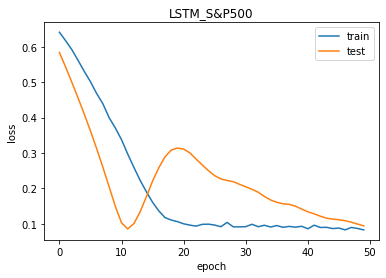

In [17]:
# Build LSTM model 
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='adam')


# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2,shuffle=False)
model.save('lstm_model.h5')
# paint the loss picture
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_S&P500', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

# 5.BackTest

In [18]:
# Predict the earn_rate
print(test_X.shape)
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_y_test = concatenate((test_X[:, :test_X.shape[1]-1],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
X = test_X[-1]
print(X)
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = concatenate((test_X[:, :test_X.shape[1]-1],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('Prediction value after nomalization:',inv_y_predict)
print('True value after nomalization:',inv_y)

(107, 1, 4)
[0.9015494  0.9024985  0.17387062 0.64594394]
Prediction value after nomalization: [-0.00045127  0.01665523  0.01737984  0.03091282  0.01710164  0.01562192
 -0.03291591  0.04040574  0.00774324  0.02006185  0.01845371  0.020032
 -0.00872938  0.05004253  0.02682961  0.02002558  0.00686438  0.02243127
  0.04367102  0.04411659  0.01615821  0.03621636  0.03754332  0.02111457
  0.10112792  0.03467065  0.01823035  0.05890974  0.03190921  0.03137993
  0.04948022  0.03043922  0.04703404  0.06124879  0.03757823  0.07420797
  0.0464799   0.05525049  0.01988002 -0.00550939  0.04555659  0.01419074
  0.02970663  0.03573374  0.01936599  0.07625746  0.02802152  0.05409836
  0.02363298  0.03998166  0.03802886  0.05753827  0.0485048   0.06013086
  0.05363709  0.05823283  0.04413177  0.07545712  0.03919994  0.02283816
  0.05253726  0.06218217  0.04101133  0.05040581  0.04923311  0.04250319
  0.02365745  0.04499785  0.02689943  0.03214217  0.06970341  0.0512177
  0.04506755  0.05958075  0.0552

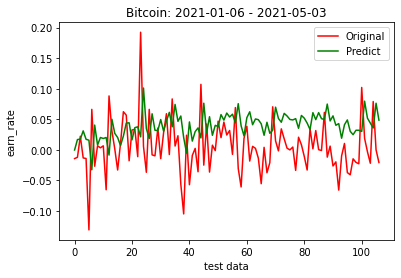

In [21]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('test data')
plt.ylabel('earn_rate')
plt.title('Bitcoin: 2021-01-06 - 2021-05-03')
plt.legend()
plt.show()

In [10]:
# Calculate MSE 
mse=mean_squared_error(inv_y,inv_y_predict)
# Calculate RMSE 
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
# Calculate MAE 
mae=mean_absolute_error(inv_y,inv_y_predict)
# Calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('mse: %.6f' % mse)
print('rmse: %.6f' % rmse)
print('mae: %.6f' % mae)
print('R_square: %.6f' % r_square)

mse: 0.000238
rmse: 0.015433
mae: 0.012912
R_square: -3.575964


# 6.Predict the earn_rate of Next Day

In [11]:
X = X.reshape((1,1,7))
from keras.models import load_model
# Load model from single model file
model = load_model('lstm_model.h5')
# Predict the earn_rate
y_predict2 = model.predict(X)
X = X.reshape((1,7))
# Invert scaling for forecast
inv_y_test2 = concatenate((X[:, :6],y_predict2), axis=1)
inv_y_test2 = scaler.inverse_transform(inv_y_test2)
inv_y_predict2=inv_y_test2[:,-1]
print('S&P500 index quote rate of next day',inv_y_predict2)

S&P500 index quote rate of next day [0.01607243]
